In [1]:
import numpy as np

# Load your EEG file
data_path = '../../../SEED-DV/EEG/sub1.npy'
locs_path = '../../../SEED-DV/channel_62_pos.locs'
eeg_data = np.load(data_path)

print("Shape of EEG data:", eeg_data.shape)

#outptut:Shape of EEG data: (7, 62, 104000)
#7 - EEG recprding for 7 videos
#62 - channels (electrodes)
#1,04,000 - timepoints / samples per video

Shape of EEG data: (7, 62, 104000)


In [6]:
%matplotlib qt

In [7]:
duration_sec = 104000 / 200
print(f"Duration of each video = {duration_sec:.2f} seconds") #520 secs

Duration of each video = 520.00 seconds


In [8]:
channel_names = []
with open(locs_path, 'r') as f:
    for line in f:
        if line.strip() and not line.startswith("#"):
            parts = line.strip().split()
            channel_names.append(parts[-1])  # last part is usually channel name

print("Loaded channel names:", channel_names)
print("Total:", len(channel_names))


Loaded channel names: ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']
Total: 62


In [10]:
import mne
import numpy as np

# Load 1st video EEG
video_1 = eeg_data[0]  # shape: (62, 104000)

# Sampling rate
sfreq = 200

# Info and RawArray
ch_types = ['eeg'] * len(channel_names)
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(video_1, info)
raw.plot(
    n_channels=30,        # number of channels to display at once
    scalings='auto',      # or {'eeg': 20e-6} to manually set
    duration=10.0,        # time (in seconds) to show per window
    start=0.0,            # start time (in seconds)
    show=True,            # display immediately
    block=True,           # block execution until closed
    title='EEG Raw Data'  # plot window title
)

raw_before_all = raw.copy()  # right after loading and montage, before any processing

Creating RawArray with float64 data, n_channels=62, n_times=104000
    Range : 0 ... 103999 =      0.000 ...   519.995 secs
Ready.
Channels marked as bad:
['CPZ']


In [11]:
import mne

def create_raw_object(data, sfreq=200):
    # Load .locs file properly via MNE
    montage = mne.channels.read_custom_montage("../../../SEED-DV/channel_62_pos.locs")

    # Extract channel names
    ch_names = montage.ch_names
    n_channels = len(ch_names)

    # Sanity check
    if data.shape[0] != n_channels:
        raise ValueError(f"Data has {data.shape[0]} channels but montage expects {n_channels}")

    # Create info and Raw object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=["eeg"] * n_channels)
    raw = mne.io.RawArray(data, info)

    # Set montage using MNE’s official method
    raw.set_montage(montage, match_case=False, on_missing='ignore')
    return raw
raw = create_raw_object(video_1)


Creating RawArray with float64 data, n_channels=62, n_times=104000
    Range : 0 ... 103999 =      0.000 ...   519.995 secs
Ready.


In [12]:
import matplotlib.pyplot as plt

# Plot scalp layout with names, following docs
fig = raw.plot_sensors(kind='topomap', show_names=True, title='Sensor Locations')
plt.show()


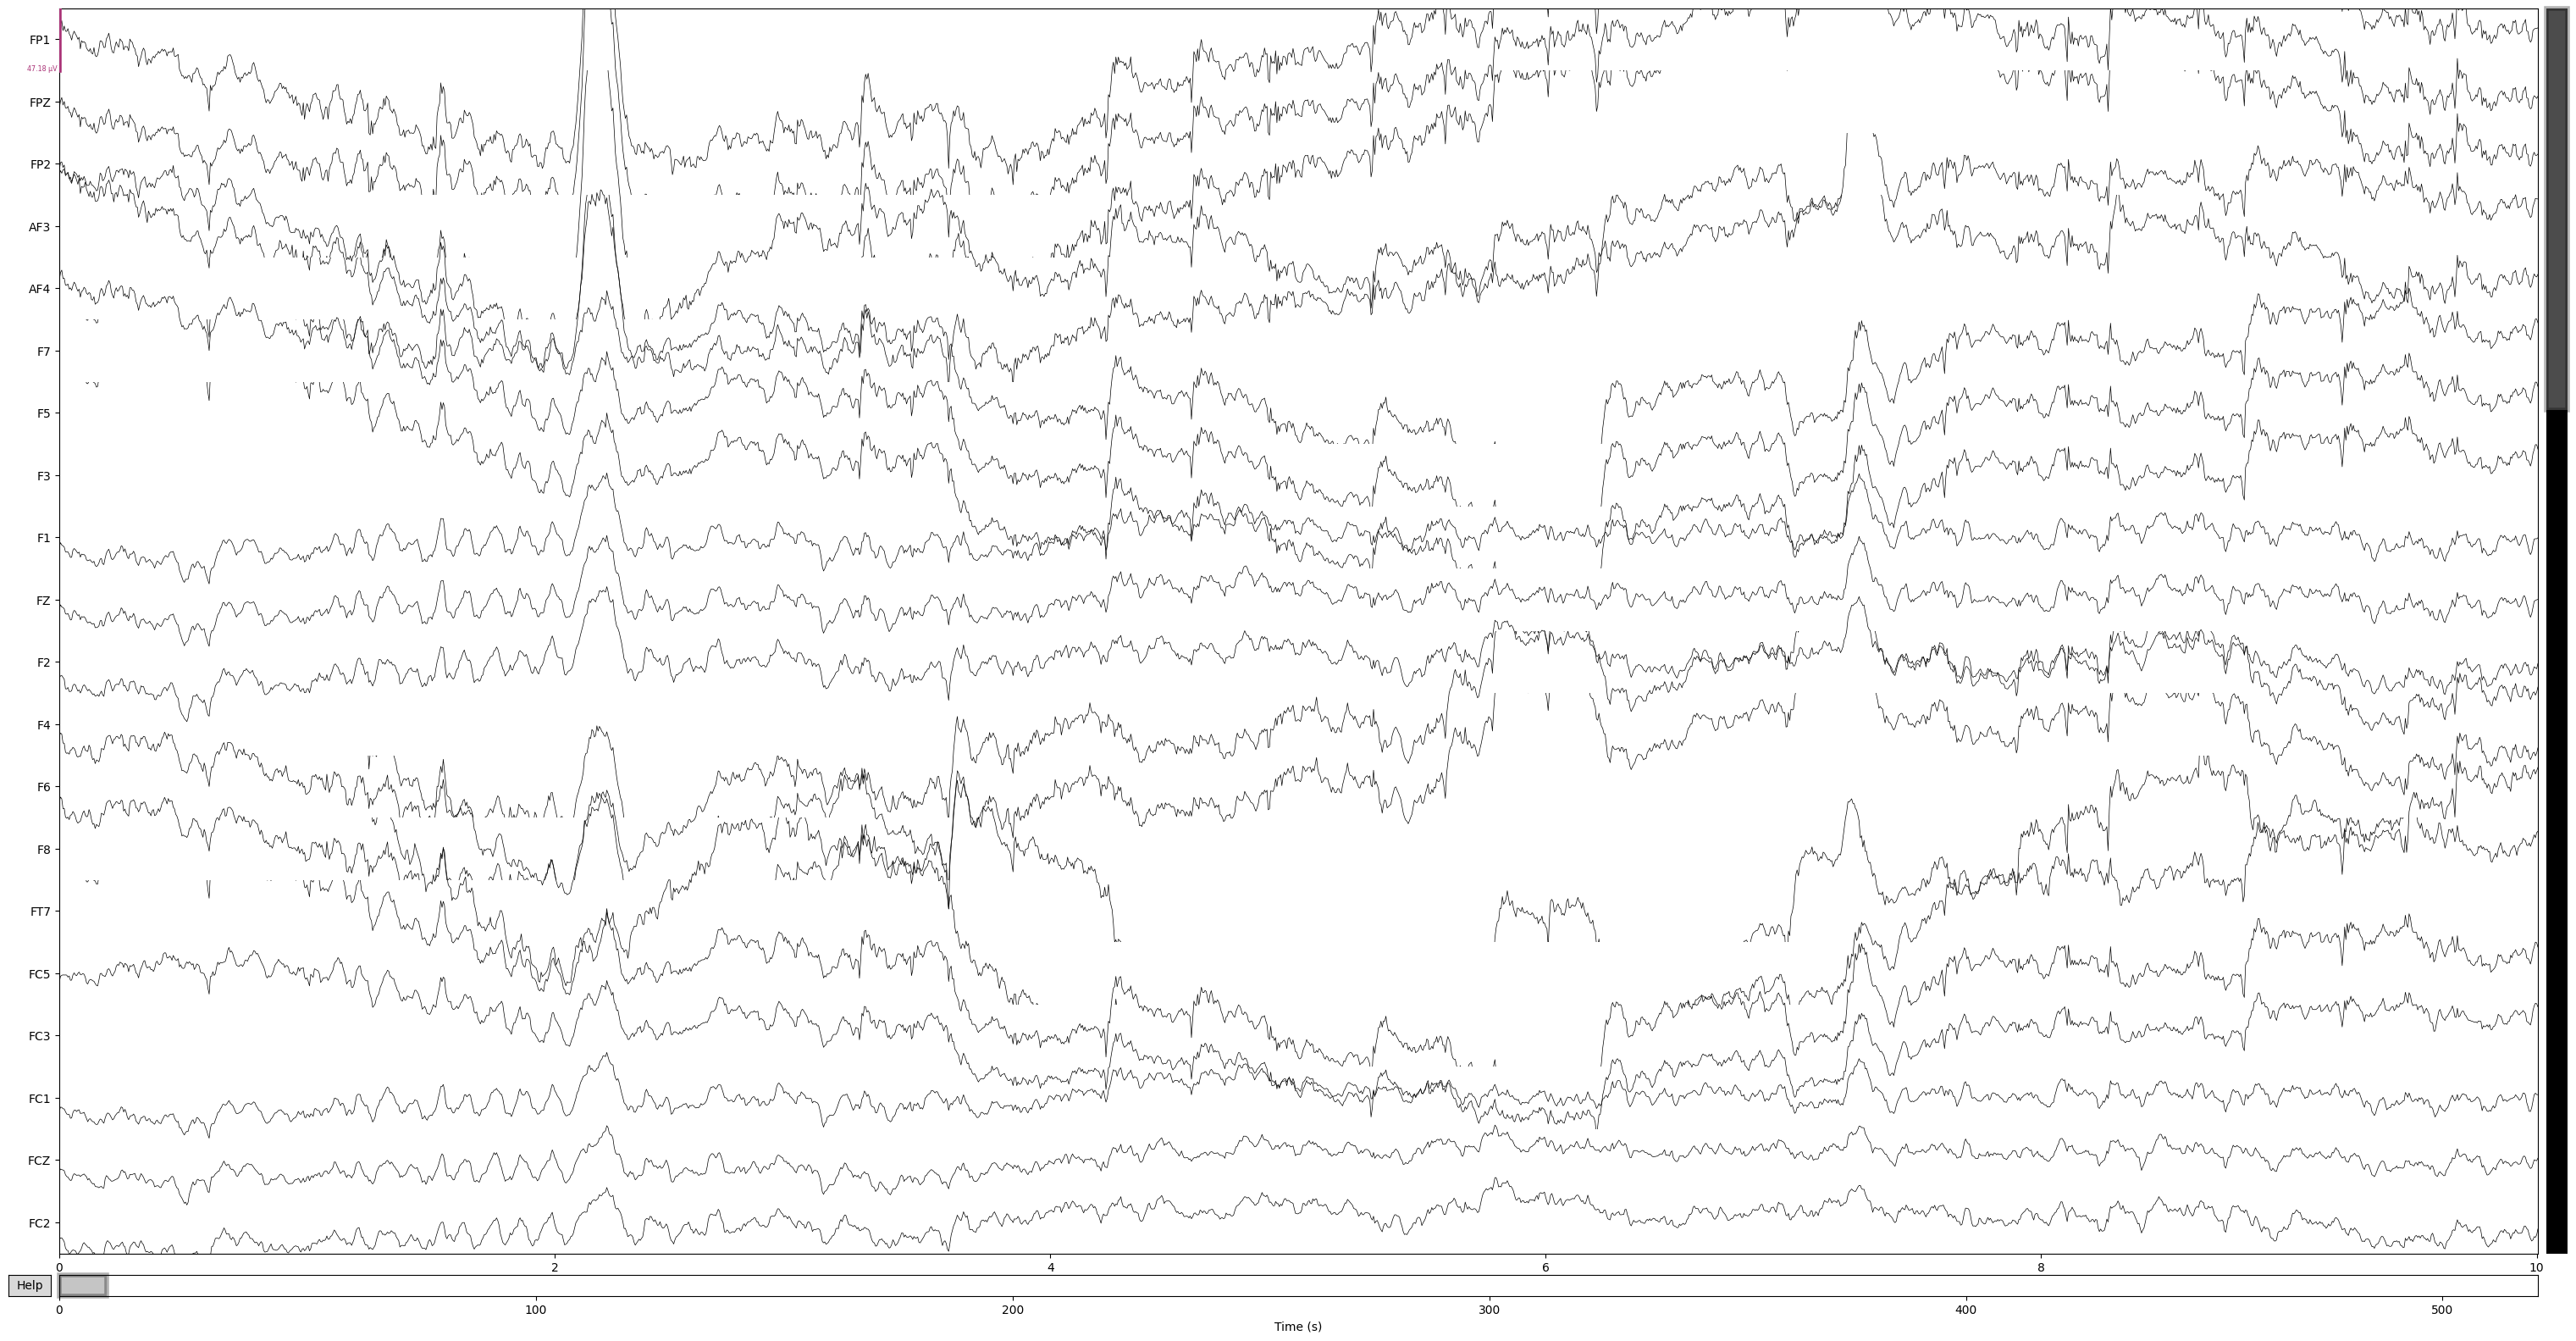

Channels marked as bad:
none


In [14]:
raw.plot(title='Raw EEG - Before Preprocessing', duration=10, scalings='auto')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


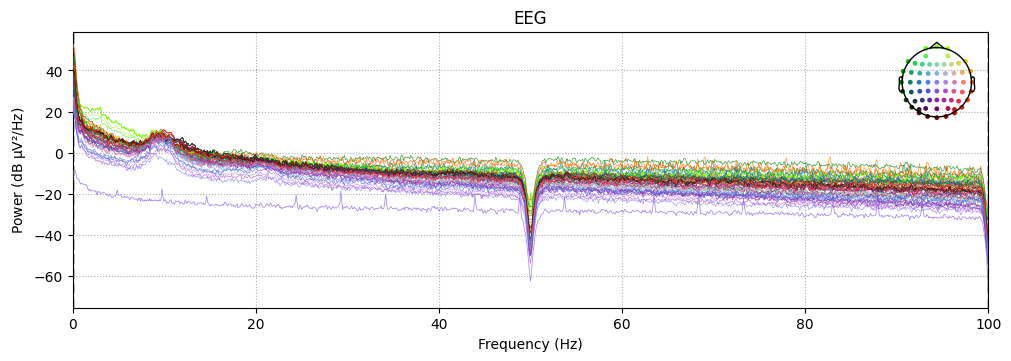

In [15]:
# delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), gamma (>30 Hz)
#PSD shows power (energy) in each frequency band
'''
helps detect-
Whether alpha rhythm is strong (usually at rest, in parietal areas)
Whether a channel is noisy (e.g., spikes in 50/60 Hz)
Whether muscle artifacts dominate (high power in 30+ Hz)
'''
#plot psd
raw.plot_psd(fmax=100, average=True)

#10 hz - peak = alpha rhythym
#50 - notch atrifact
raw.compute_psd().plot()


In [50]:
#bad channel removal - manual
# raw.plot(title='Mark Bad Channels by Clicking', duration=10, scalings='auto')
raw.info['bads']
#interpolate bad channels
raw.interpolate_bads()

Setting channel interpolation method to {'eeg': 'spline'}.


/tmp/ipython-input-50-2855248398.py:5: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


<RawArray | 62 x 104000 (520.0 s), ~49.3 MiB, data loaded>

In [16]:
#doing based on z scores on log power of channels to detect abnormally noise ones
import numpy as np
import matplotlib.pyplot as plt

# Compute PSD directly from raw
psd = raw.compute_psd(fmin=1, fmax=50, n_fft=1024)

# Get PSD data and freqs
psds = psd.get_data()
freqs = psd.freqs

# Convert to dB
psds_db = 10 * np.log10(psds)

# Mean log power per channel
mean_psd = psds_db.mean(axis=1)

# Z-score based outlier detection
z_scores = (mean_psd - np.mean(mean_psd)) / np.std(mean_psd)

# Threshold for bad channel detection
threshold = 3
bad_channel_indices = np.where(np.abs(z_scores) > threshold)[0]
bad_channels = [raw.ch_names[i] for i in bad_channel_indices]

print("Bad channels detected (z > 3):", bad_channels)


Effective window size : 5.120 (s)
Bad channels detected (z > 3): ['CPZ']


In [17]:
#visualising the z scores
plt.figure(figsize=(12, 4))
plt.bar(raw.ch_names, z_scores)
plt.axhline(threshold, color='r', linestyle='--', label='Threshold = ±3')
plt.axhline(-threshold, color='r', linestyle='--')
plt.ylabel('Z-score of Log Power')
plt.title('Z-score of Log Power (1–50 Hz) per Channel')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 1 sensors


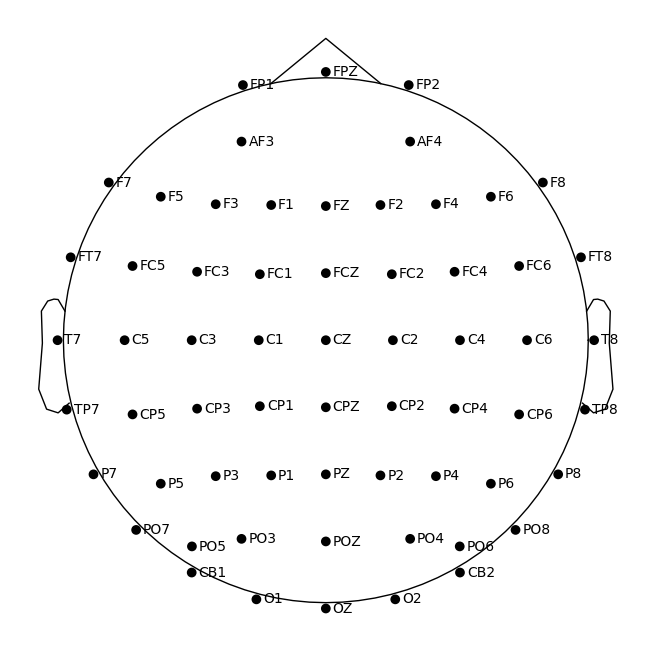

Channels marked as bad:
none


In [18]:
#scalp plot after interpolating(revising using neigbours) bad channels
raw.info['bads'] = bad_channels
raw.interpolate_bads()
raw.plot(title='After Interpolation of Bad Channels')
raw.plot_sensors(kind='topomap', show_names=True)

#until now
| Step                                 | What You Did                                          | Why It Mattered                                     |
| ------------------------------------ | ----------------------------------------------------- | --------------------------------------------------- |
| ✅ Loaded `sub1.npy`                  | Got EEG data from SEED-DV                             | Data shape: (7 videos, 62 channels, 104000 samples) |
| ✅ Used `.locs` file                  | Assigned real-world scalp positions                   | Enables meaningful topomaps and spatial plots       |
| ✅ Created `RawArray`                 | Converted data into MNE-compatible format             | Required for preprocessing                          |
| ✅ Set montage                        | Used custom `.locs` montage                           | Accurate scalp mapping                              |
| ✅ Viewed initial PSD                 | Checked spectral power (noted 10 Hz peak, 50 Hz drop) | Baseline check for data quality                     |
| ✅ Detected bad channels (e.g. `CPz`) | Used automated bad channel detection                  | Identified outliers                                 |
| ✅ Interpolated bad channels          | Fixed bad data while preserving structure             | Keeps spatial context intact                        |


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


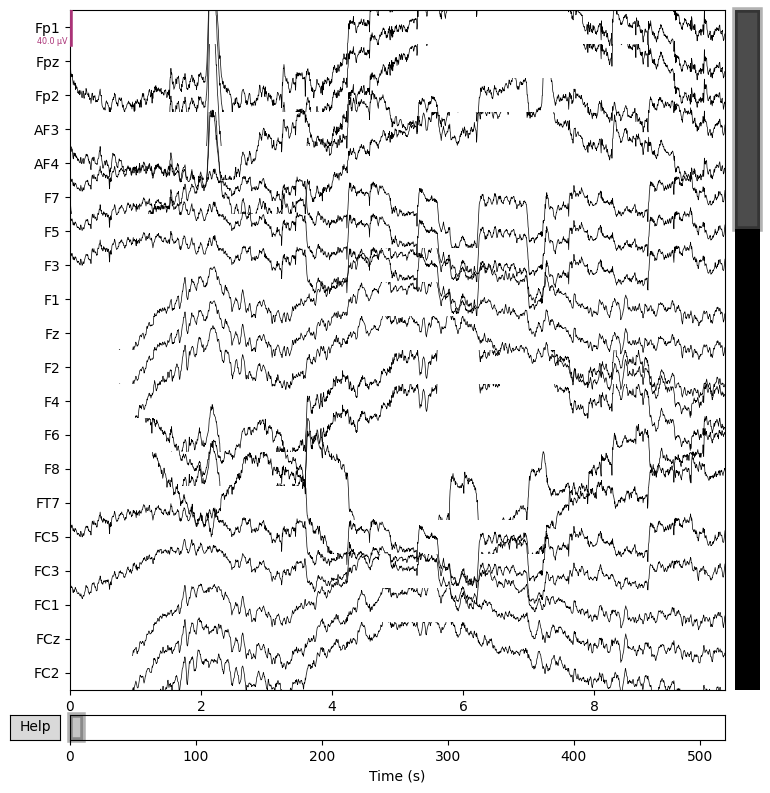

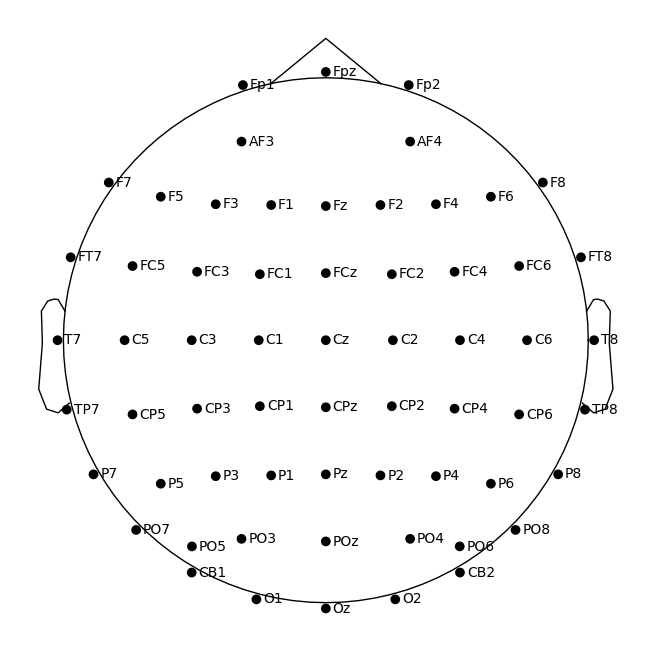

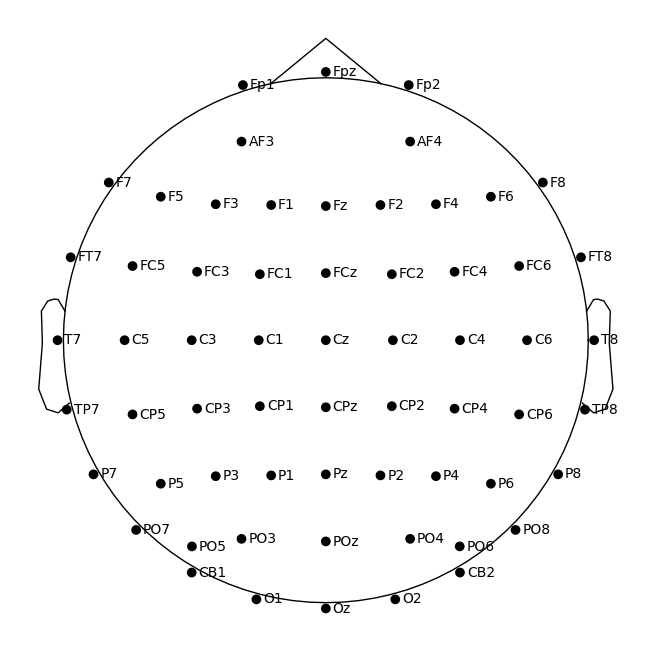

In [54]:
#re referencing
'''
Every EEG signal is relative — the voltage is measured between two electrodes. Re-referencing is like resetting the "zero" level by choosing a new baseline to compare all signals against.

why?
removed shared noise
spatial resolution improved
avoids any channel being over / under expressed

startergies -
average
mastoids - behinf ears electrodes = A1, A2 #arent present
linked ears - avg of A1 A2
specific channel - Cz, one thats isnt bad
'''

# Apply average reference
raw.set_eeg_reference('average', projection=False)

# Plot scalp again to visualize change
raw.plot(title = 'after re referencing based in avg')
raw.plot_sensors(kind='topomap', show_names=True)


In [19]:
# Before re-referencing (save for comparison)
raw_before = raw.copy().pick_types(eeg=True)

# Apply re-referencing
raw.set_eeg_reference('average', projection=False)

# After re-referencing
raw_after = raw.copy().pick_types(eeg=True)

# Compare power spectral density before and after
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
raw_before.plot_psd(fmin=1, fmax=50, ax=ax[0], show=False)
ax[0].set_title("Before Re-referencing")

raw_after.plot_psd(fmin=1, fmax=50, ax=ax[1], show=False)
ax[1].set_title("After Re-referencing")

plt.tight_layout()
plt.show()




NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_61099/568582256.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [20]:
#ica
from mne.preprocessing import ICA

# Set random seed for reproducibility
ica = ICA(n_components=20, random_state=97, method='fastica')
ica.fit(raw)  # raw is your cleaned, re-referenced data





Fitting ICA to data using 62 channels (please be patient, this may take a while)


/tmp/ipykernel_61099/4102608983.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)  # raw is your cleaned, re-referenced data


Selecting by number: 20 components
Fitting ICA took 2.4s.


<ICA | raw data decomposition, method: fastica (fit in 62 iterations on 104000 samples), 20 ICA components (62 PCA components available), channel types: eeg, no sources marked for exclusion>

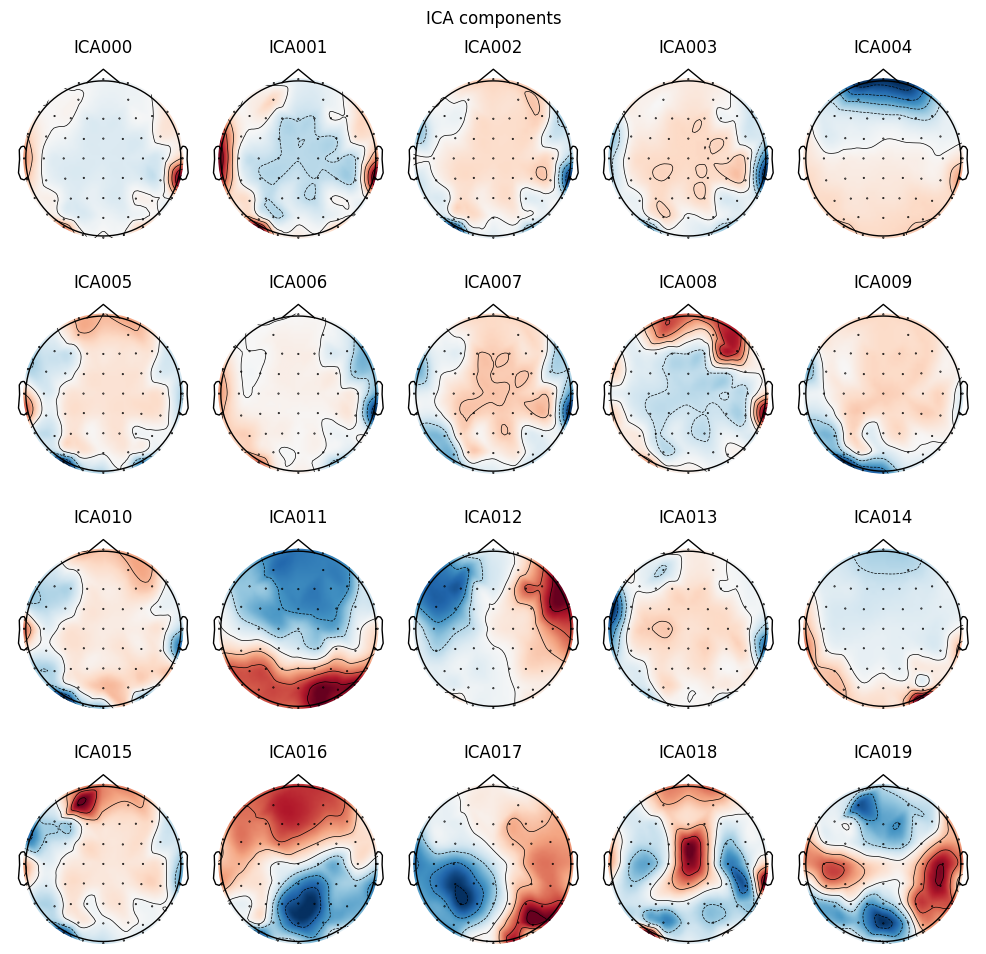

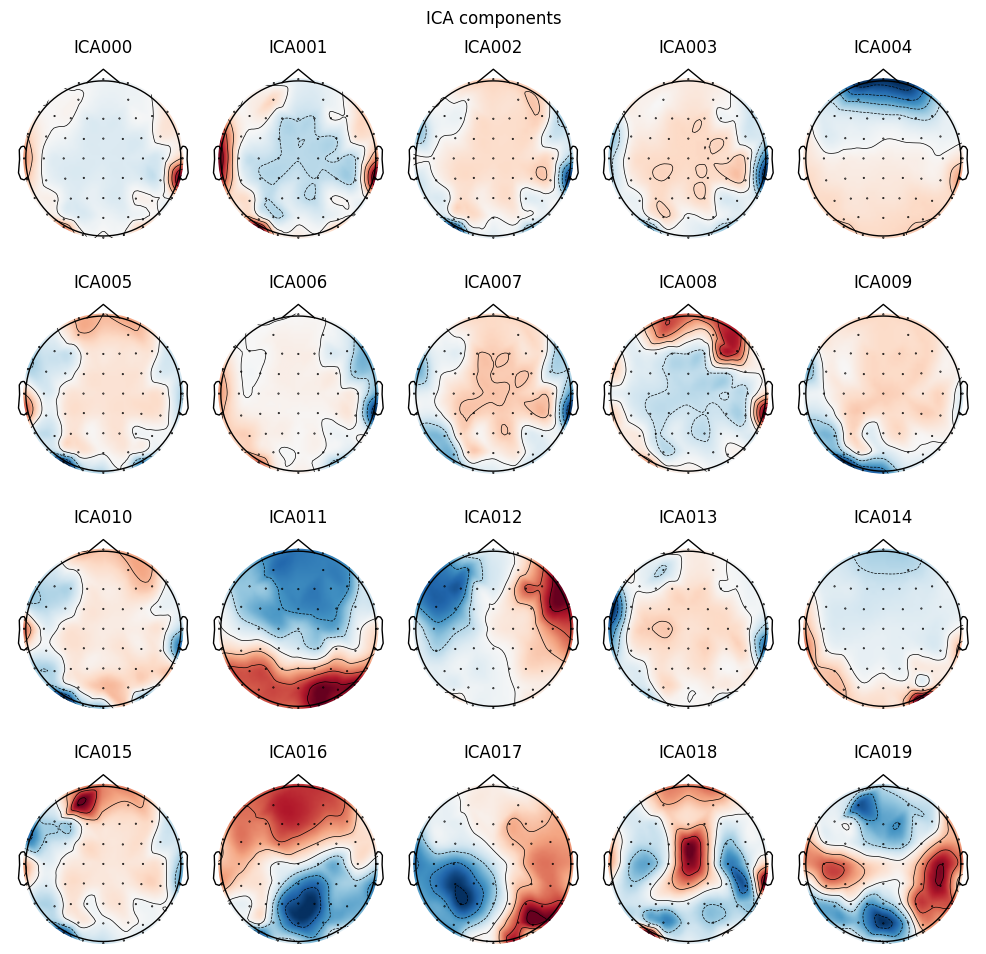

In [57]:
ica.plot_components()


Creating RawArray with float64 data, n_channels=20, n_times=104000
    Range : 0 ... 103999 =      0.000 ...   519.995 secs
Ready.


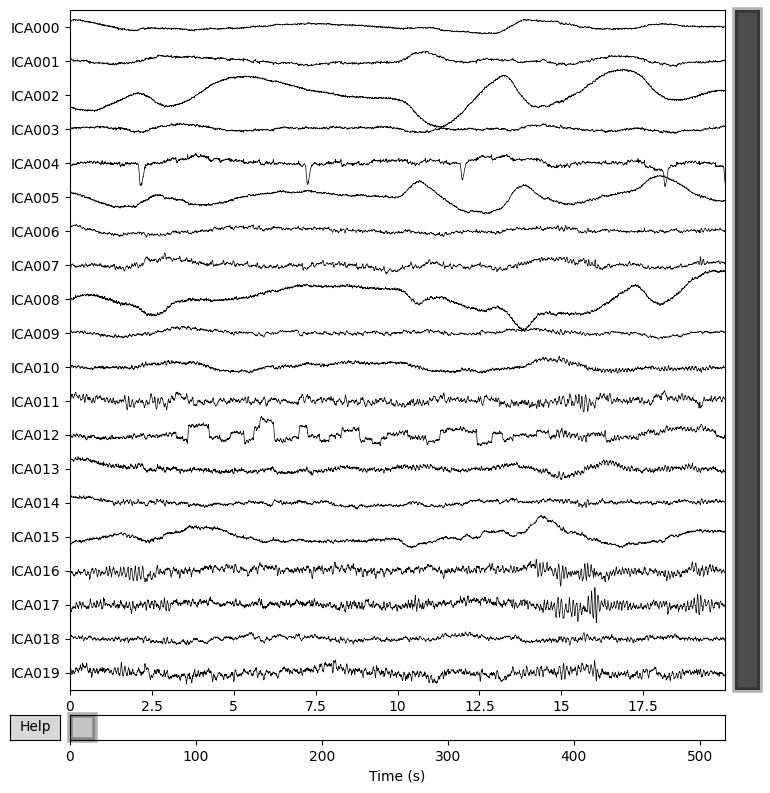

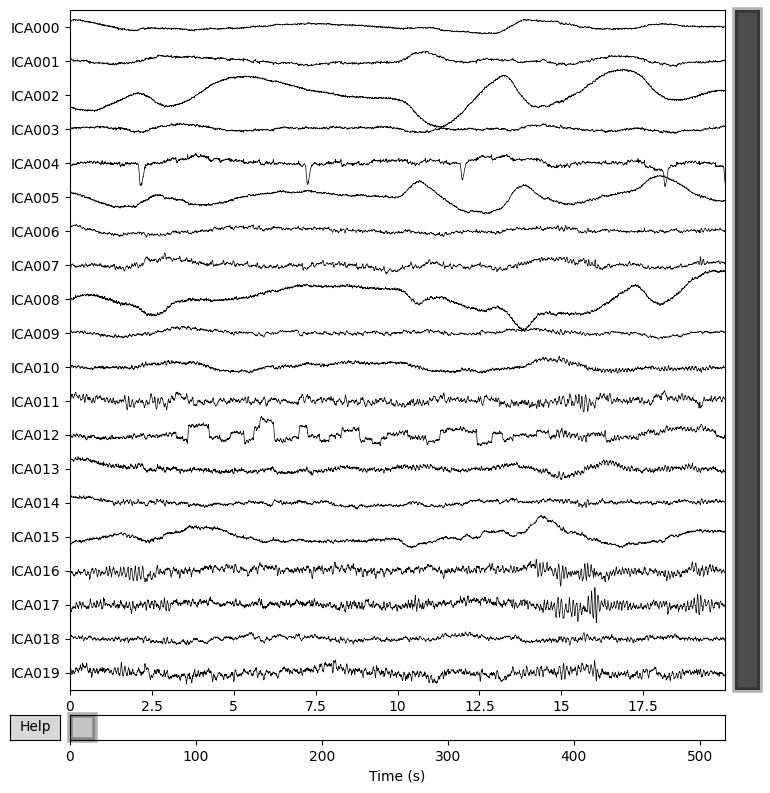

In [58]:
ica.plot_sources(raw, show_scrollbars=True)


In [21]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw, threshold=0.8)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(f"Automatically detected muscle-related ICA components: {muscle_idx_auto}")


Effective window size : 10.240 (s)
Automatically detected muscle-related ICA components: []


In [22]:
print(raw._data.shape)
print(raw.info)
# Fit ICA on high-pass filtered data
raw_ica = raw.copy().filter(l_freq=1.0, h_freq=None)
ica.fit(raw_ica)
ica.plot_sources(raw_ica)
muscle_idx_auto, scores = ica.find_bads_muscle(raw_ica, threshold = 0.67)
ica.plot_properties(raw_ica, picks=muscle_idx_auto, log_scale=True)
ica.plot_scores(scores, exclude=muscle_idx_auto)

print(
      "Automatically found muscle artifact ICA components: "
      f"{muscle_idx_auto}"
    )

(62, 104000)
<Info | 9 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG
 custom_ref_applied: True
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 200.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)

Fitting ICA to data using 62 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 20 components
Fitting ICA took 2.9s.
Creating RawArray with float64 data, n_channels=20, n_times=104000
    Range : 0 ... 103999 =      0.000 ...   519.995 secs
Ready.
Effective window size : 10.240 (s)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Automatically found muscle artifact ICA components: [1, 11, 18, 19]


In [23]:
print(raw._data.shape)

(62, 104000)


In [24]:
import numpy as np
from mne.time_frequency import psd_array_welch
import matplotlib.pyplot as plt

# Get ICA source time series (shape: n_components, n_times)
ica_sources = ica.get_sources(raw).get_data()
sfreq = raw.info['sfreq']
n_components = ica_sources.shape[0]

# Compute average power in 20–50 Hz for each component
psd_avg = []
for i in range(n_components):
    psd, freqs = psd_array_welch(
        ica_sources[i][np.newaxis, :],  # Ensure shape is (1, n_times)
        sfreq=sfreq,
        fmin=20,
        fmax=50,
        n_fft=1024
    )
    psd_avg.append(np.mean(psd))  # Mean power over frequency

# Convert to array and normalize
psd_avg = np.array(psd_avg)
threshold = psd_avg.mean() + 2 * psd_avg.std()  # Conservative threshold

# Identify likely muscle components
muscle_like_components = np.where(psd_avg > threshold)[0]

# Display results
print("Likely muscle artifact ICA components:", muscle_like_components)

# Plot only the suspicious components (optional)
if len(muscle_like_components) > 0:
    ica.plot_components(picks=muscle_like_components)
else:
    print("No components crossed the threshold — consider loosening it.")


Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Effective window size : 5.120 (s)
Likely muscle artifact ICA components: [18 19]


In [25]:
ica.exclude = muscle_idx_auto
raw_cleaned = ica.apply(raw.copy())


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 62 PCA components


Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


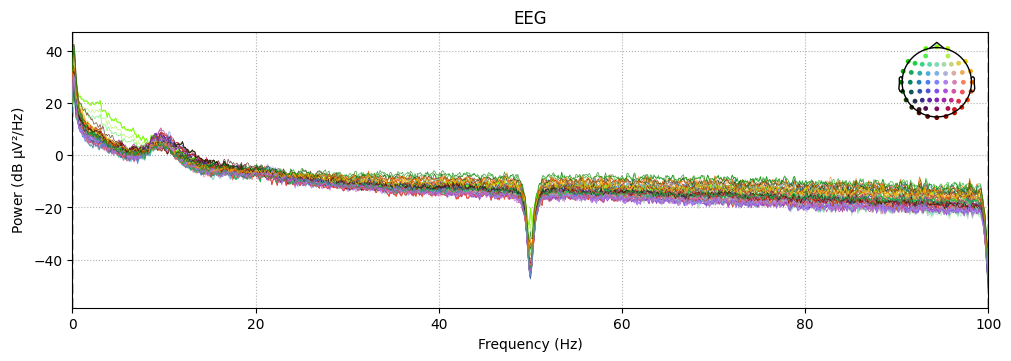

In [26]:
# Compare PSDs
raw.compute_psd().plot()
raw_cleaned.compute_psd().plot()


Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2601 original time points ...
2 bad epochs dropped
Created 78 epochs, each 13.0s long
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


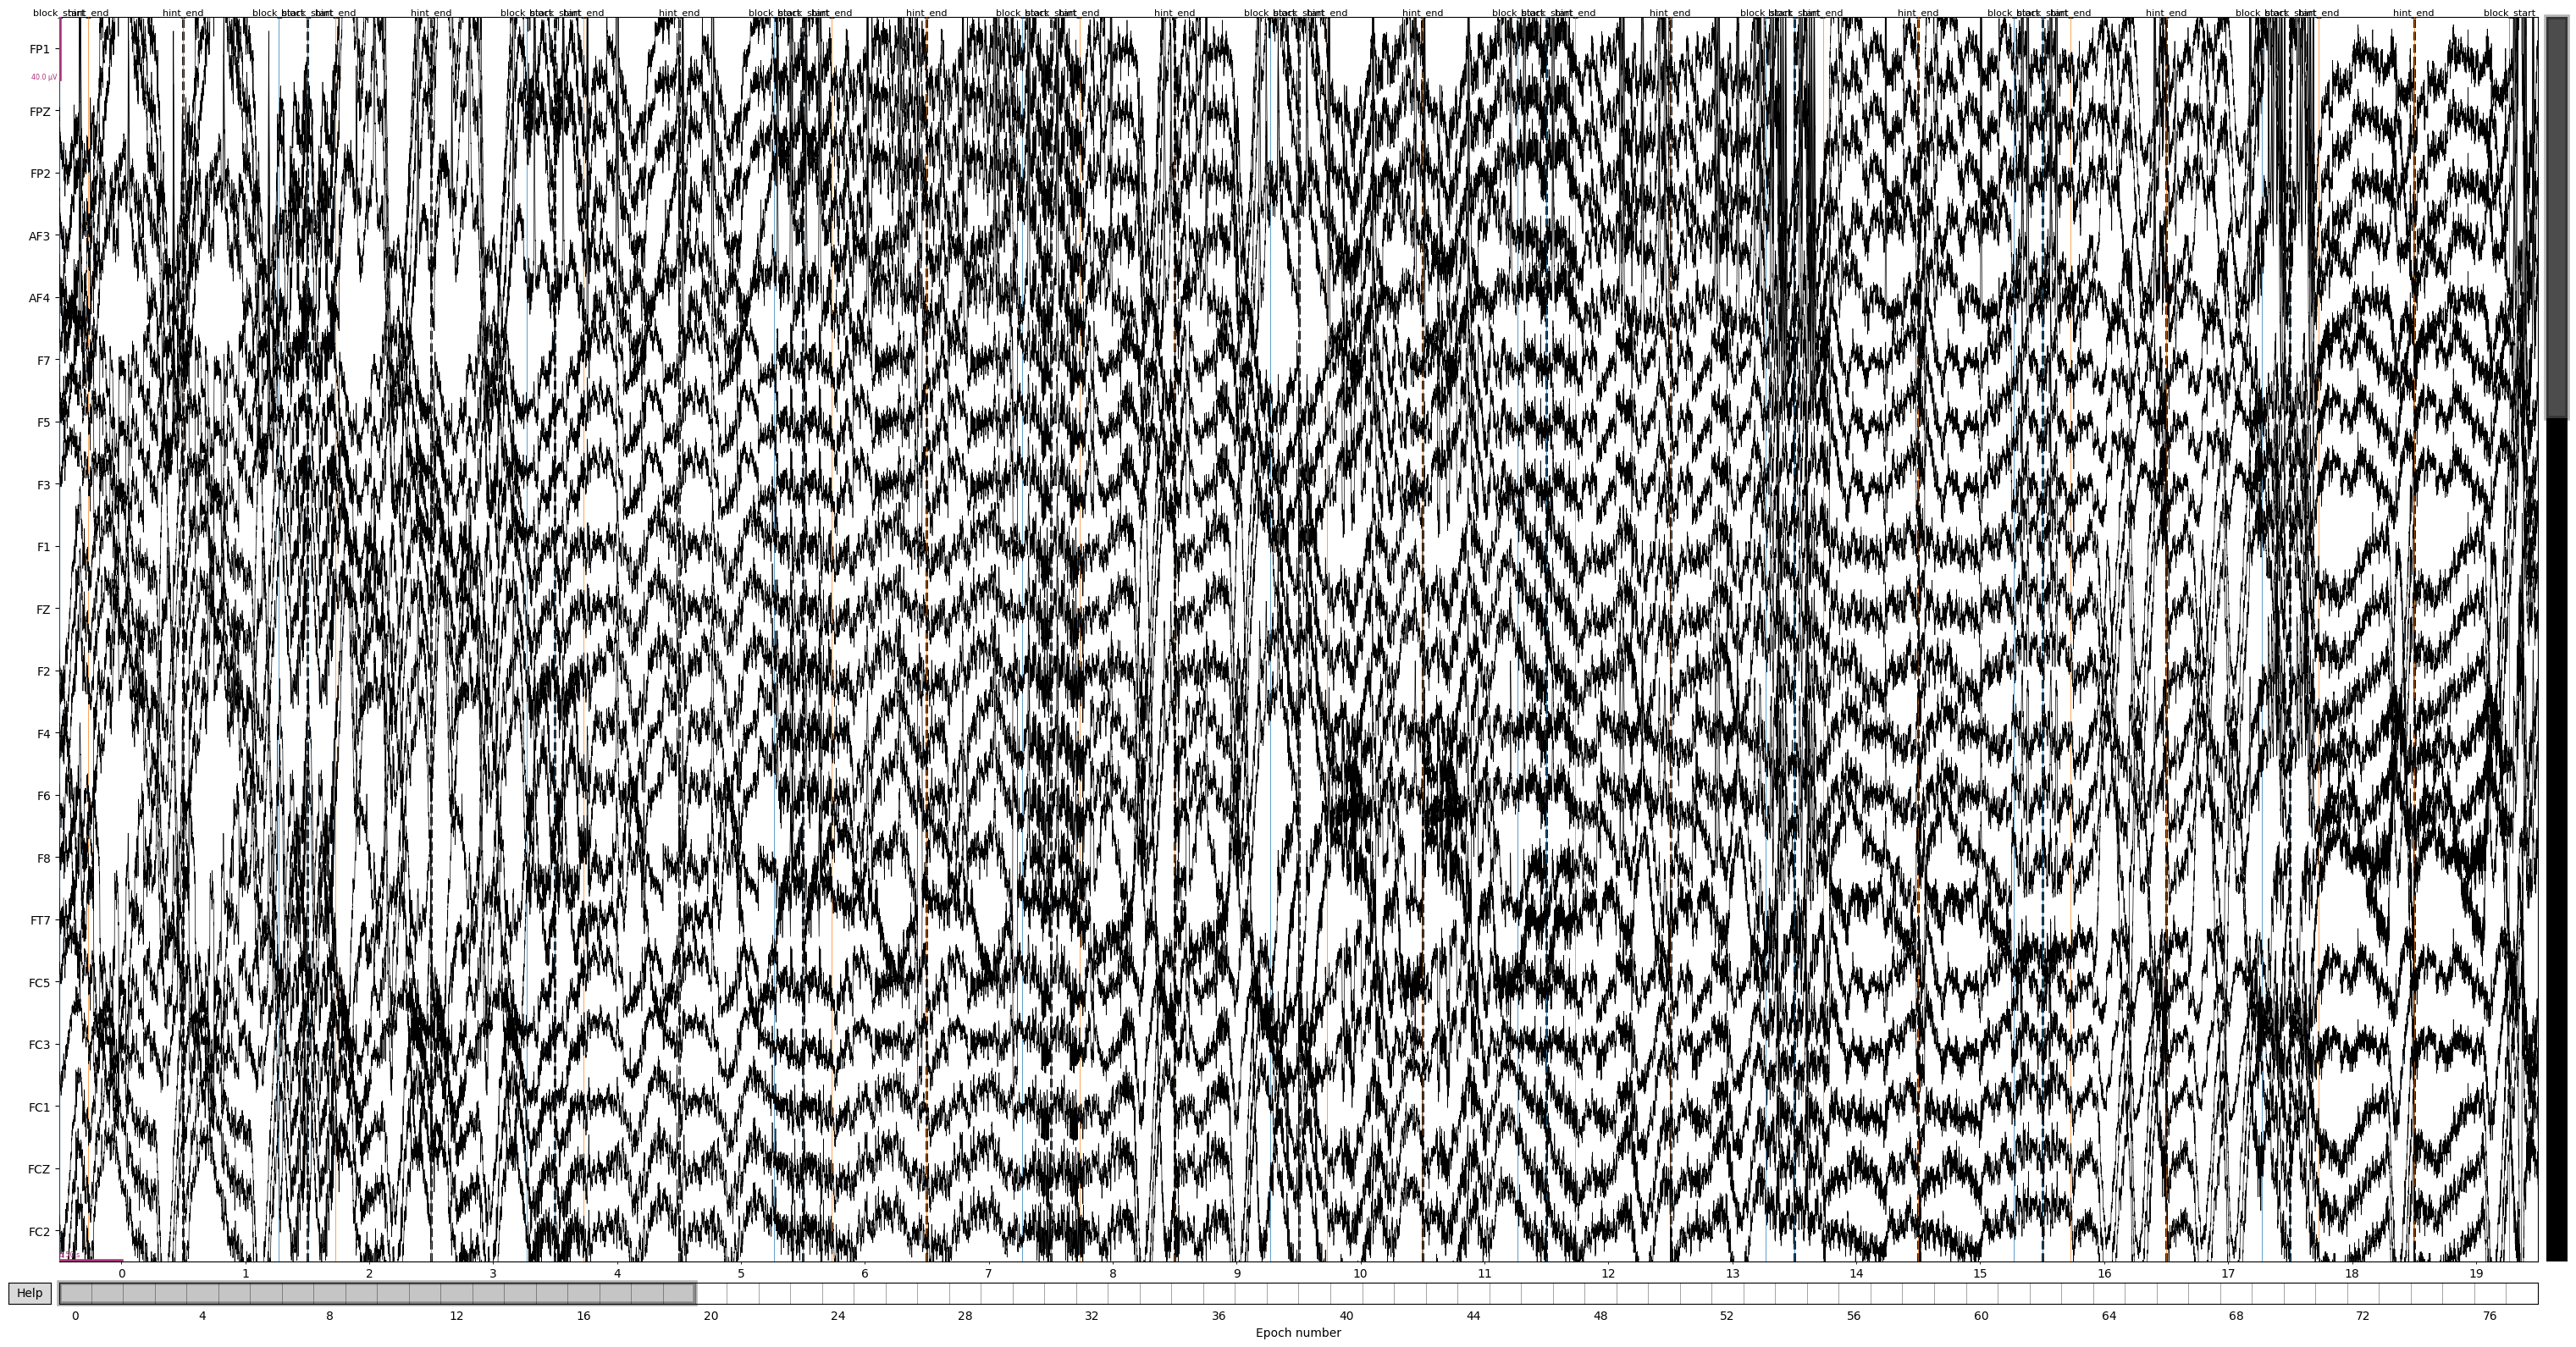

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [27]:
import numpy as np
import mne

# Sampling frequency (ensure this matches your data, SEED-DV uses 200 Hz)
sfreq = raw.info['sfreq']

# Parameters
block_duration = 13.0  # each video block is 13 seconds
hint_duration = 3.0    # visual hint ends at 3s
n_blocks = 40          # total blocks/trials in SEED-DV

# Initialize events list
events = []

for i in range(n_blocks):
    block_start = i * block_duration
    block_start_sample = int(block_start * sfreq)
    hint_end_sample = block_start_sample + int(hint_duration * sfreq)

    # Event 1: Start of the block (used to create the epoch)
    events.append([block_start_sample, 0, 1])  # 1 = block_start

    # Event 2: Hint ends at 3s (marker inside the epoch)
    events.append([hint_end_sample, 0, 2])     # 2 = hint_end

# Convert to MNE-style event array
events = np.array(events, dtype=int)

# Create Epochs object
epochs = mne.Epochs(
    raw,
    events,
    event_id={'block_start': 1, 'hint_end': 2},
    tmin=0.0,
    tmax=block_duration,
    baseline=None,
    preload=True
)

# View number of epochs
print(f"Created {len(epochs)} epochs, each {block_duration}s long")

# Optional: plot epochs and hint-end events
epochs.plot(events=epochs.events, event_id={'hint_end': 2})


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


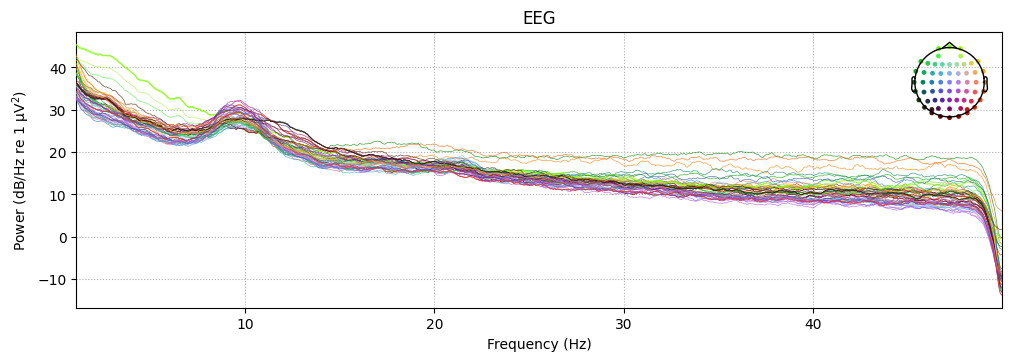

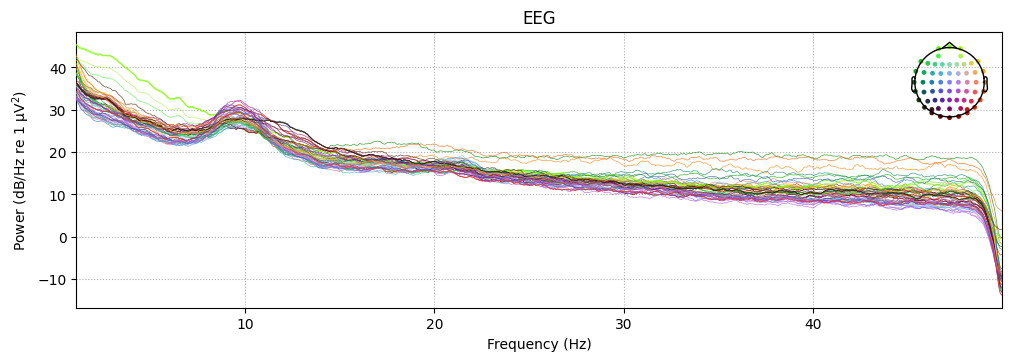

In [66]:
epochs.plot_psd(fmin=1, fmax=50)  # Show PSD of each epoch


In [67]:
print(epochs)  # Summary of number of epochs, time range, etc.
print(epochs.get_data().shape)  # Should be (40, 62, 2600)


<Epochs | 78 events (all good), 0 – 13 s (baseline off), ~96.0 MiB, data loaded,
 'block_start': 39
 'hint_end': 39>
(78, 62, 2601)


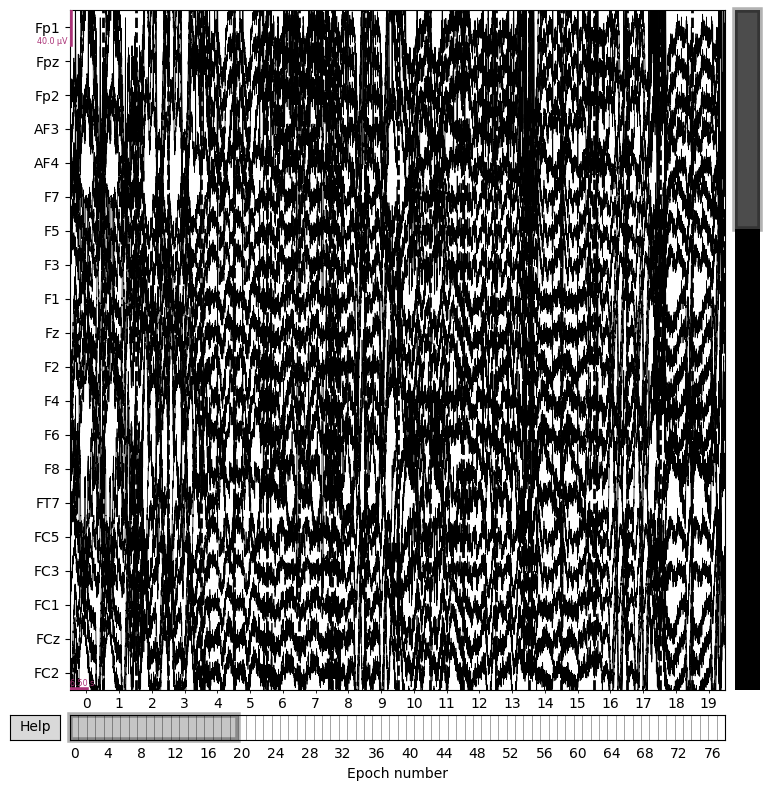

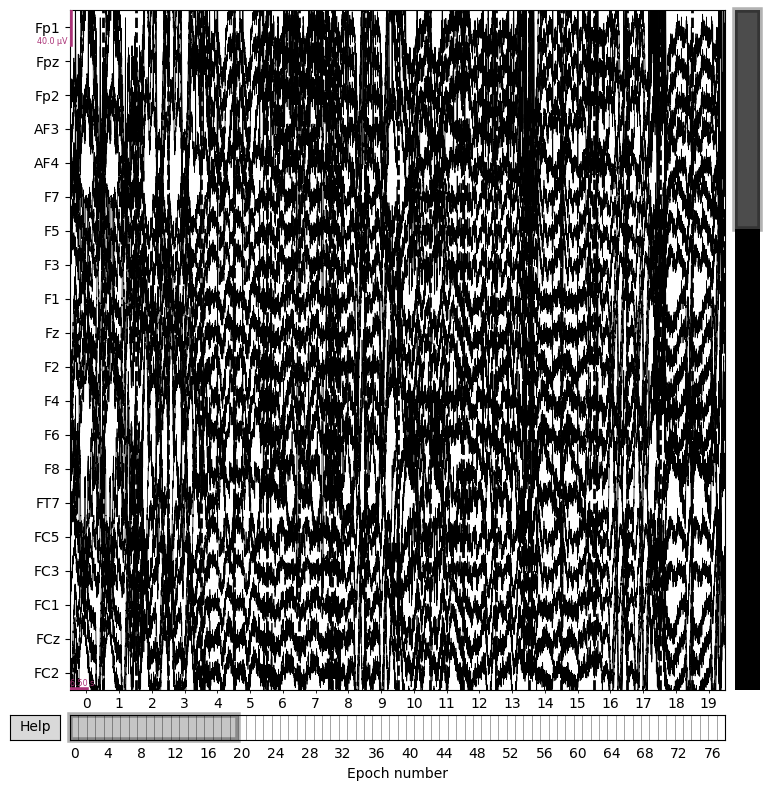

In [68]:
epochs.plot()

In [69]:
# raw_before_all = raw.copy()  # right after loading and montage, before any processing
raw_after_all = raw  # after all preprocessing (interpolation, referencing, ICA)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


/tmp/ipython-input-70-4105484599.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_before_all.plot_psd(fmin=1, fmax=50, ax=ax[0], show=False)


Plotting power spectral density (dB=True).


/tmp/ipython-input-70-4105484599.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


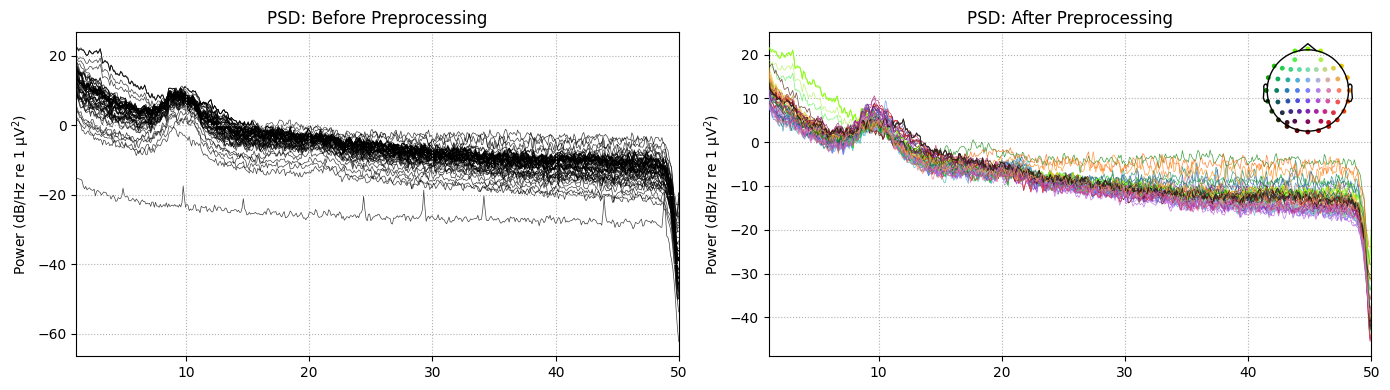

RuntimeError: No valid channel positions found

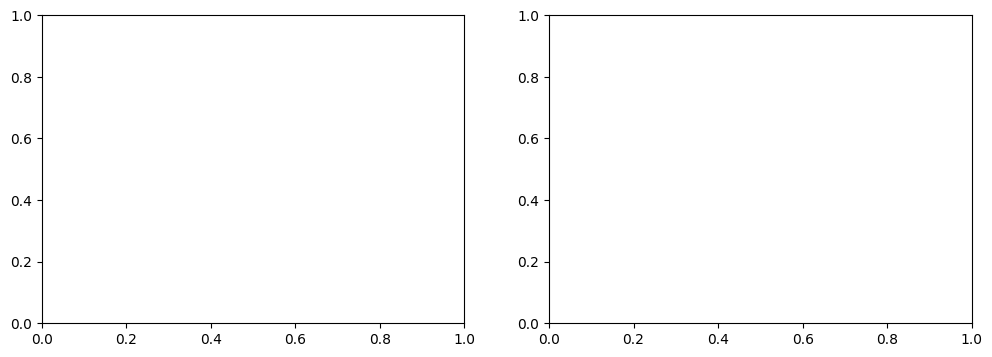

In [70]:
import matplotlib.pyplot as plt

# 1. PSD Comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
raw_before_all.plot_psd(fmin=1, fmax=50, ax=ax[0], show=False)
ax[0].set_title("PSD: Before Preprocessing")

raw.plot_psd(fmin=1, fmax=50, ax=ax[1], show=False)
ax[1].set_title("PSD: After Preprocessing")
plt.tight_layout()
plt.show()

# 2. Scalp Map (topomap) Comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
raw_before_all.plot_sensors(kind='topomap', axes=ax[0], show=False, show_names=True)
ax[0].set_title("Sensor Map: Before Preprocessing")

raw.plot_sensors(kind='topomap', axes=ax[1], show=False, show_names=True)
ax[1].set_title("Sensor Map: After Preprocessing")
plt.tight_layout()
plt.show()


In [ ]:
ch_idx = raw.ch_names.index('CPz')  # Or any available channel name
times = raw.times[:3000]  # First 5 seconds approx (at 200Hz)

plt.figure(figsize=(12, 4))
plt.plot(times, raw_before_all._data[ch_idx, :3000], label='Before', alpha=0.6)
plt.plot(times, raw._data[ch_idx, :3000], label='After', alpha=0.6)
plt.title(f"EEG Signal Comparison for Channel {raw.ch_names[ch_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
np.allclose(raw_before_all._data[ch_idx, :3000], raw._data[ch_idx, :3000])


In [ ]:
def save_data( epochs, subject_id):
    """Save preprocessed data."""
    print("  Saving data...")

    data = epochs.get_data()

    # Save numpy array
    output_file = output_dir / f"{subject_id}_preprocessed.npy"
    np.save(output_file, data)

    # Save metadata
    metadata = {
        'subject_id': subject_id,
        'shape': data.shape,
        'sfreq': epochs.info['sfreq'],
        'ch_names': epochs.ch_names,
        'n_epochs': len(epochs),
        'preprocessing_steps': [
            'bandpass_filter_0.5_40Hz',
            'notch_filter_50Hz',
            'common_average_reference',
            'bad_channel_detection',
            'ICA_artifact_removal',
            'epoching_13s',
            'z_score_normalization'
        ]
    }

    metadata_file = output_dir / f"{subject_id}_metadata.npy"
    np.save(metadata_file, metadata)

    print(f"    Saved: {output_file}")
    print(f"    Shape: {data.shape}")

    return output_file

from pathlib import Path
output_dir = Path('/content/drive/MyDrive/SEED-DV/EEG')

save_data(epochs, 2)